<a href="https://colab.research.google.com/github/manoranjan11/kaggle/blob/master/Janata%20Hack%3A%20Steam/Steam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#install required versions of libraries 
!pip3 install --quiet tensorflow-hub
!pip3 install --quiet seaborn
!pip3 install pyspellchecker

In [2]:
#importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from collections import defaultdict
import nltk
from nltk.corpus import stopwords

from nltk.util import ngrams
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer

import re
from spellchecker import SpellChecker

import tensorflow as tf
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split
import itertools
import datetime
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Lambda, SpatialDropout1D, Dense
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam,Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers


from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant
from keras.optimizers import Adadelta

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [3]:
#link to github repository
!rm -r kaggle
!git clone https://github.com/manoranjan11/kaggle.git

Cloning into 'kaggle'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 24 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (24/24), done.


In [0]:
# Importing the dataset
train_dataset = pd.read_csv('/content/kaggle/Janata Hack: Steam/train.csv')
test_dataset = pd.read_csv('/content/kaggle/Janata Hack: Steam/test.csv')

In [5]:
train_dataset.head()

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1


Text(0, 0.5, 'samples')

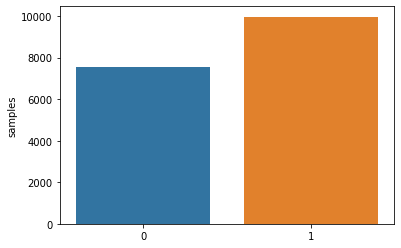

In [6]:
#class distribution
x=train_dataset.user_suggestion.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

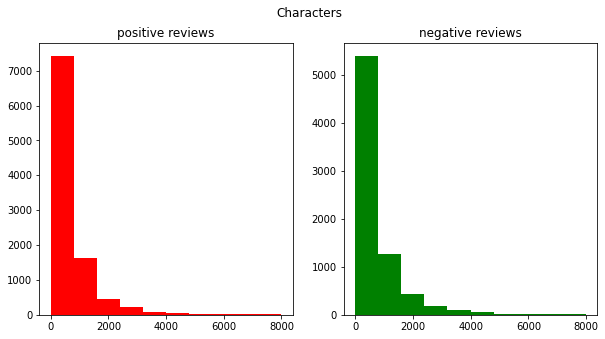

In [7]:
#character analysis
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train_dataset[train_dataset['user_suggestion']==1]['user_review'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('positive reviews')
tweet_len=train_dataset[train_dataset['user_suggestion']==0]['user_review'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('negative reviews')
fig.suptitle('Characters')
plt.show()

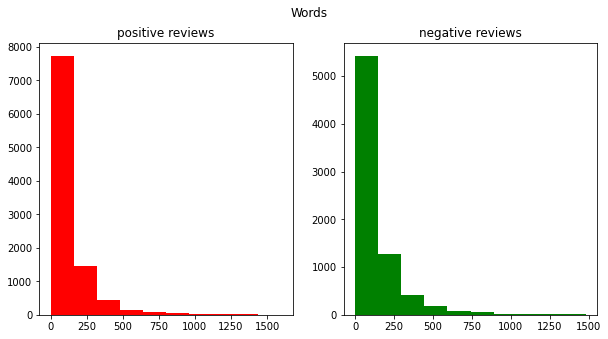

In [8]:
#word analysis
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train_dataset[train_dataset['user_suggestion']==1]['user_review'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('positive reviews')
tweet_len=train_dataset[train_dataset['user_suggestion']==0]['user_review'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('negative reviews')
fig.suptitle('Words')
plt.show()

Text(0.5, 0.98, 'Average word length in each review')

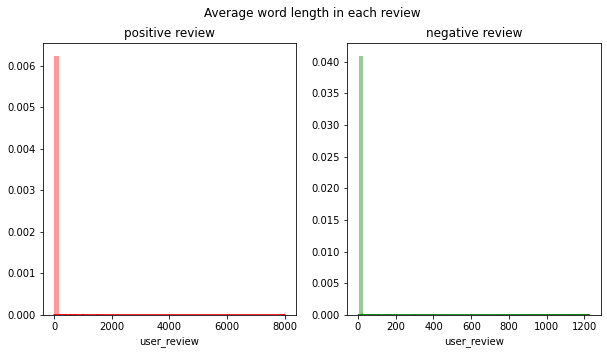

In [9]:
#Average word length
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train_dataset[train_dataset['user_suggestion']==1]['user_review'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('positive review')
word=train_dataset[train_dataset['user_suggestion']==0]['user_review'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('negative review')
fig.suptitle('Average word length in each review')

In [0]:
#create corpus
def create_corpus(target):
    corpus=[]
    
    for x in train_dataset[train_dataset['user_suggestion']==target]['user_review'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<BarContainer object of 10 artists>

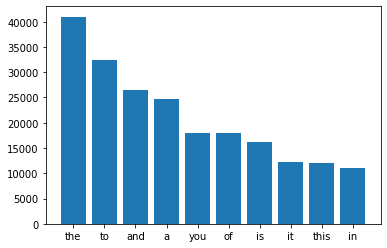

In [12]:
#analyze target=0
corpus=create_corpus(0)
stop=set(stopwords.words('english'))
dic=defaultdict(int)

for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

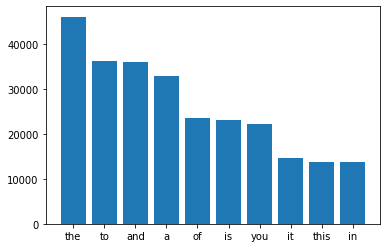

In [13]:
#analyze target=1
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    
x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 31 artists>

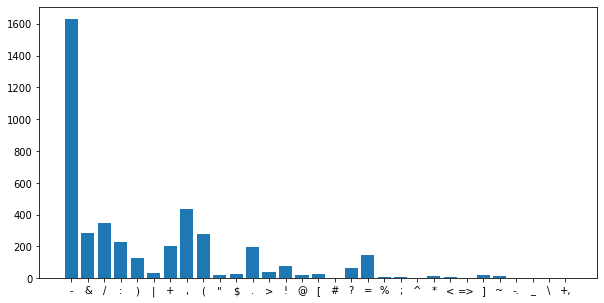

In [14]:
#analyze punctuations in target=1
plt.figure(figsize=(10,5))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

<BarContainer object of 31 artists>

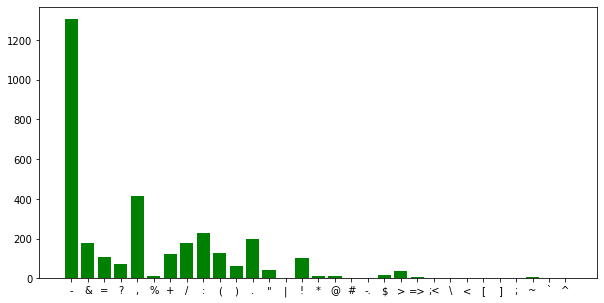

In [15]:
#analyze punctuations in target=0
plt.figure(figsize=(10,5))
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='green')

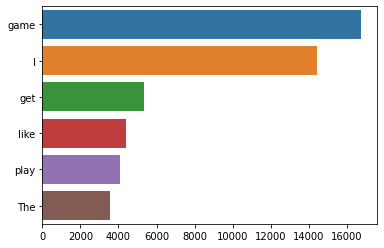

In [16]:
#Common Words
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

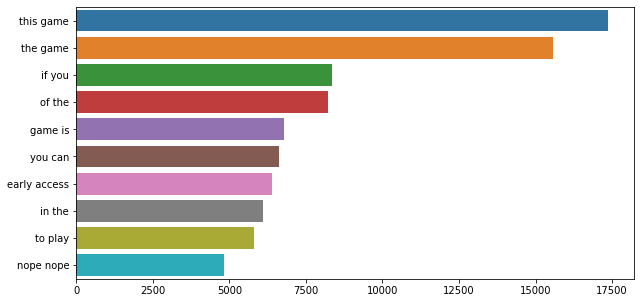

In [17]:
#ngram analysis
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(train_dataset['user_review'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

In [18]:
#Data Cleaning
#df=pd.concat([train_dataset,test_dataset])
#df.shape

example="New competition launched :https://www.kaggle.com/c/nlp-getting-started"

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

remove_URL(example)

train_dataset['user_review']=train_dataset['user_review'].apply(lambda x : remove_URL(x))
test_dataset['user_review']=test_dataset['user_review'].apply(lambda x : remove_URL(x))

example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

print(remove_html(example))

train_dataset['user_review']=train_dataset['user_review'].apply(lambda x : remove_html(x))
test_dataset['user_review']=test_dataset['user_review'].apply(lambda x : remove_html(x))

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

train_dataset['user_review']=train_dataset['user_review'].apply(lambda x : remove_emoji(x))
test_dataset['user_review']=test_dataset['user_review'].apply(lambda x : remove_emoji(x))

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="I am a #king"
print(remove_punct(example))

train_dataset['user_review']=train_dataset['user_review'].apply(lambda x : remove_punct(x))
test_dataset['user_review']=test_dataset['user_review'].apply(lambda x : remove_punct(x))

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
text = "corect me plese"
correct_spellings(text)

#train_dataset['text']=train_dataset['text'].apply(lambda x : correct_spellings(x))
#test_dataset['text']=test_dataset['text'].apply(lambda x : correct_spellings(x))


Real or Fake
Kaggle 
getting started

I am a king


'correct me please'

In [19]:
test_dataset.head()

,review_id,title,year,user_review
0,1603,Counter-Strike: Global Offensive,2015.0,Nice graphics new maps weapons and models But ...
1,1604,Counter-Strike: Global Offensive,2018.0,I would not recommend getting into this at its...
2,1605,Counter-Strike: Global Offensive,2018.0,Edit 111218I have tried playing CSGO recently ...
3,1606,Counter-Strike: Global Offensive,2015.0,The game is great But the community is the wor...
4,1607,Counter-Strike: Global Offensive,2015.0,I thank TrulyRazor for buying this for me a lo...


In [0]:
#test google encoder in TF2
hub_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5"
embed = hub.load(hub_url)

In [0]:
X_train = train_dataset.iloc[:, 3].values
y_train = train_dataset.iloc[:, 4].values

In [0]:
#splitting into test & train
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [0]:
X_test = test_dataset.iloc[:, 3].values

In [24]:
len(X_test)

8045

In [0]:
X_train_embed = []

In [0]:
for i in range(0,len(X_train)):
  temp = embed([X_train[i]])
  X_train_embed.append(temp)

In [0]:
X_test_embed = []

In [0]:
for i in range(0,len(X_test)):
  temp = embed([X_test[i]])
  X_test_embed.append(temp)

In [29]:
len(X_test_embed)

8045

In [0]:
temp1 = y_train
#temp2 = y_test

In [0]:
temp1 = np.asarray(temp1)
#temp2 = np.asarray(temp2)

In [0]:
X_train_embed = np.asarray(X_train_embed)
X_test_embed = np.asarray(X_test_embed)

In [0]:
#Building a model
model1 = Sequential()

In [0]:
model1.add(Input(shape=(1,512), dtype='float32'))
model1.add(SpatialDropout1D(0.2))
model1.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model1.add(Dense(1, activation='sigmoid'))

optimzer=Adam(learning_rate=1e-5)

model1.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [46]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spatial_dropout1d_1 (Spatial (None, 1, 512)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                147712    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 147,777
Trainable params: 147,777
Non-trainable params: 0
_________________________________________________________________


In [0]:
from time import time
import datetime
n_epoch = 100

In [47]:
training_start_time = time()

trained = model1.fit(X_train_embed, temp1, batch_size=64, epochs=n_epoch)

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

Epoch 1/100
274/274 [==============================] - 1s 4ms/step - loss: 0.6909 - accuracy: 0.5691
Epoch 2/100
274/274 [==============================] - 1s 4ms/step - loss: 0.6868 - accuracy: 0.5939
Epoch 3/100
274/274 [==============================] - 1s 4ms/step - loss: 0.6827 - accuracy: 0.5799
Epoch 4/100
274/274 [==============================] - 1s 4ms/step - loss: 0.6787 - accuracy: 0.5767
Epoch 5/100
274/274 [==============================] - 1s 4ms/step - loss: 0.6745 - accuracy: 0.5756
Epoch 6/100
274/274 [==============================] - 1s 4ms/step - loss: 0.6704 - accuracy: 0.5763
Epoch 7/100
274/274 [==============================] - 1s 4ms/step - loss: 0.6659 - accuracy: 0.5777
Epoch 8/100
274/274 [==============================] - 1s 4ms/step - loss: 0.6614 - accuracy: 0.5796
Epoch 9/100
274/274 [==============================] - 1s 4ms/step - loss: 0.6574 - accuracy: 0.5819
Epoch 10/100
274/274 [==============================] - 1s 4ms/step - loss: 0.6526 - accura

In [0]:
model2 = Sequential()

In [0]:
model2.add(Input(shape=(1,512), dtype='float32'))
model2.add(SpatialDropout1D(0.2))
model2.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model2.add(Dense(1, activation='sigmoid'))

optimzer=tf.keras.optimizers.SGD(learning_rate=1.5,momentum = 0.25)

model2.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [87]:
model2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spatial_dropout1d_10 (Spatia (None, 1, 512)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                147712    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 147,777
Trainable params: 147,777
Non-trainable params: 0
_________________________________________________________________


In [90]:
training_start_time = time()

trained = model2.fit(X_train_embed, temp1, batch_size=64, epochs=n_epoch,validation_split=0.2)

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

Epoch 1/150
219/219 [==============================] - 1s 5ms/step - loss: 0.2977 - accuracy: 0.8685 - val_loss: 0.4887 - val_accuracy: 0.7788
Epoch 2/150
219/219 [==============================] - 1s 5ms/step - loss: 0.2999 - accuracy: 0.8695 - val_loss: 0.4198 - val_accuracy: 0.8122
Epoch 3/150
219/219 [==============================] - 1s 5ms/step - loss: 0.2995 - accuracy: 0.8696 - val_loss: 0.4942 - val_accuracy: 0.7768
Epoch 4/150
219/219 [==============================] - 1s 5ms/step - loss: 0.2974 - accuracy: 0.8705 - val_loss: 0.4202 - val_accuracy: 0.8068
Epoch 5/150
219/219 [==============================] - 1s 5ms/step - loss: 0.2980 - accuracy: 0.8705 - val_loss: 0.4903 - val_accuracy: 0.7745
Epoch 6/150
219/219 [==============================] - 1s 5ms/step - loss: 0.2933 - accuracy: 0.8739 - val_loss: 0.4138 - val_accuracy: 0.8102
Epoch 7/150
219/219 [==============================] - 1s 5ms/step - loss: 0.2915 - accuracy: 0.8737 - val_loss: 0.4452 - val_accuracy: 0.7934

In [0]:
y_pred = model2.predict(X_test_embed)

In [49]:
len(y_pred)

8045

In [0]:
from sklearn.metrics import f1_score


In [0]:
for i in range(0,len(y_pred)):
  if y_pred[i]>=0.5:
    y_pred[i] = 1
  else:
    y_pred[i] = 0

In [42]:
y_pred

array([[1.],
       [0.],
       [0.],
       ...,
       [0.],
       [1.],
       [1.]], dtype=float32)

In [0]:
np.savetxt(fname="y_pred.csv", delimiter=",", X=y_pred)

In [69]:
f1_score(temp2,y_pred)

0.8793144489407283